In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.ndimage import gaussian_filter1d, median_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

## Define I(Q)

In [2]:
def S_hs(QD, phi):
    alpha = (1 + 2 * phi)**2 / (1 - phi)**4
    beta = -6 * phi * (1 + phi / 2)**2 / (1 - phi)**4
    gama = phi * alpha / 2
    
    G_hs = (alpha * (np.sin(QD) - QD * np.cos(QD)) / QD**2 +
            beta * (2 * QD * np.sin(QD) + (2 - QD**2) * np.cos(QD) - 2) / QD**3 +
            gama * (-QD**4 * np.cos(QD) + 4 * ((3 * QD**2 - 6) * np.cos(QD) +
            (QD**3 - 6 * QD) * np.sin(QD) + 6)) / QD**5)
    
    S = 1 / (24 * phi * G_hs/ QD + 1)
    
    return S

def P_hs(QD):
    P = (3*(np.sin(QD/2)-QD/2*np.cos(QD/2))/(QD/2)**3)**2
    P[QD==0] = 1    
    return P

In [3]:
q_grid = np.linspace(-12, 12, 128)
n_grid = len(q_grid)**2
qx, qy = np.meshgrid(q_grid, q_grid)
q_rad = np.sqrt(qx**2 + qy**2)
bin_edges = np.append(q_grid - (q_grid[1] - q_grid[0]) / 2, q_grid[-1] + (q_grid[1] - q_grid[0]) / 2)
d_bins = bin_edges[1] - bin_edges[0]
q = q_grid[q_grid > 0]

def f_I_q(n_sample, p_qxy, seed =1145141):
    np.random.seed(seed)
    n_pixel = n_sample/p_qxy.shape[0]  # number of samples per pixel

    # Flatten the arrays
    qx_flat = qx.flatten()
    qy_flat = qy.flatten()
    p_qxy_flat = p_qxy.flatten()

    # Normalize the probability density
    p_qxy_flat /= p_qxy_flat.sum()

    # Randomly choose indices based on the probability density
    indices = np.random.choice(len(qx_flat), size=n_sample, p=p_qxy_flat)

    # Get the sampled qx and qy values
    qx_samples = qx_flat[indices]
    qy_samples = qy_flat[indices]

    # evaluate the sampled point density in each grid

    I_q_grid, xedges, yedges = np.histogram2d(qx_samples, qy_samples, bins=[bin_edges, bin_edges])

    return I_q_grid

def f_I_q_rad(I_q_grid, q):
    # evaluate the radial averaged density
    q = q_grid[q_grid > 0]
    I_q = np.zeros_like(q)
    sum_q = np.zeros_like(q)
    n_pixels_q = np.zeros_like(q)
    I_pixels_q = []
    for i in range(len(q)):
        mask = (q_rad >= q[i] - (q[1] - q[0]) / 2) & (q_rad < q[i] + (q[1] - q[0]) / 2)
        I_pixels = I_q_grid[mask]
        sum_q[i] = I_pixels.sum()
        n_pixels_q[i] = mask.sum()
        I_q[i] = I_pixels.mean()
        
        I_pixels_q.append(I_pixels)
        
        
    return I_q, sum_q, n_pixels_q, I_pixels_q

In [4]:
I_inc = 5e-3
p_qxy = P_hs(q_rad*1.5)*S_hs(q_rad*1.5, 0.3) + I_inc
# p_qxy =p_debye(q_rad, Rg=1)+ I_inc
p_qxy[np.isfinite(p_qxy)==0] = 0
# p_qxy = np.ones_like(q_rad)
p_qxy = p_qxy/np.sum(p_qxy)

## GPR on different data quality

In [5]:
def f_loglin(x, x_c=1):
    return np.where(x < x_c, (x-x_c)/x_c+np.log(x_c), np.log(x))
def f_loglin_inv(y, y_c=0):
    return np.where(y < y_c, (1+y-y_c)*np.exp(y_c), np.exp(y))
def f_loglin_deriv(x, x_c=1):
    return np.where(x < x_c, 1/x_c, 1/x)

def f_mse(y, y_gt):
    return np.mean((y-y_gt)**2)/np.mean((y_gt)**2)

def desmear(Q,IQ,IQ_er,sigma_Q,n=3,sigmascale=1):
    I_ex = IQ
    I_ex_pos = I_ex[2*n:]
    I_ex_neg = I_ex[:-2*n]
    I_ex = I_ex[n:-n]
    sigma_Q_c = sigma_Q[n:-n]/sigmascale
    # sigma_Q_c = Q[n:-n]

    DQ = Q[n:] - Q[:-n]
    DQ_pos = DQ[n:]
    DQ_neg = DQ[:-n]

    I_ex2 = 2*(DQ_neg*I_ex_pos + DQ_pos*I_ex_neg - I_ex*(DQ_pos+DQ_neg))/(DQ_pos*DQ_neg*(DQ_pos+DQ_neg))
    I_des = I_ex - sigma_Q_c**2/2*I_ex2
    Q_des = Q[n:-n]

    # DI_ex = IQ_er
    # DI_ex[DI_ex==0] = np.min(DI_ex[DI_ex>0])
    # DI_ex_pos = DI_ex[2*n:]
    # DI_ex_neg = DI_ex[:-2*n]
    # DI_ex = DI_ex[n:-n]

    # DI_ex2_Sq = 4*((DQ_neg*DI_ex_pos)**2 + (DQ_pos*DI_ex_neg)**2 + ((DQ_neg+DQ_pos)*DI_ex)**2)/(DQ_pos*DQ_neg*(DQ_pos+DQ_neg))
    # DI_des = DI_ex*(1+sigma_Q_c**4/4*DI_ex2_Sq/DI_ex**2)
    
    return I_des

def f_log_likelihood(y, y_err, x, x_err, importance=np.ones_like(q), z_list = np.linspace(0, 0, 1)):
    """
    likelihood of y in the distribution of x
    """
    ## average over the ovservation uncertainty   
    log_likelihood = 0   
    sum_weight = 0  
    for z in z_list:
        weight_z = np.exp(-z**2/2)/np.sqrt(2*np.pi)
        y_z = y + y_err*z
        log_likelihood_z = -0.5 * np.sum(((y_z - x)**2 / x_err**2 + np.log(2 * np.pi * x_err**2)))
        log_likelihood += log_likelihood_z*weight_z
        sum_weight += weight_z
    log_likelihood = log_likelihood/sum_weight
    return log_likelihood



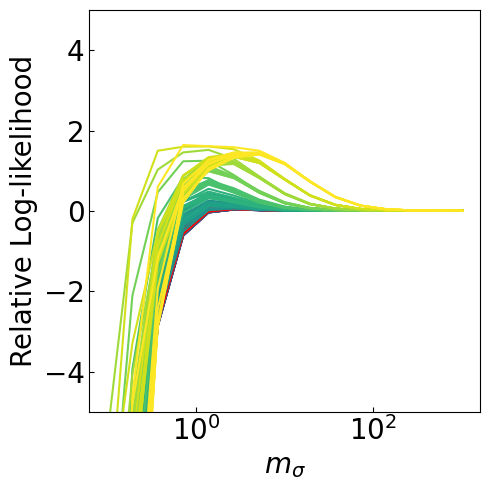

In [38]:
n_trial = 8
filter_size = 0.4
I_bg = I_inc
use_log_I = False
use_log_Q = False

# Transformations on Q and I(Q)
f_Q = lambda q: q
f_inv_Q = lambda fq: fq
if use_log_Q:
    f_Q = lambda q: np.log(q)
    f_inv_Q = lambda fq: np.exp(fq)


f_I = lambda I: I
f_inv_I = lambda fI: fI
# if use_log_I:
#     f_I = lambda I: np.log(I+I_bg)
#     f_inv_I = lambda fI: np.exp(fI)-I_bg
if use_log_I:
    f_I = lambda I: f_loglin(I, x_c=I_bg*2)
    f_inv_I = lambda fI: f_loglin_inv(fI, y_c=np.log(I_bg*2))

def get_viridis_color(value):
    cmap = plt.get_cmap('viridis')
    return cmap(value)

fig = plt.figure(figsize=(5, 5))

# n_sample_list = np.array([1000, 2000, 5000, 10000, 20000, 50000, 100000])
# n_sample_list = np.linspace(1000, 20000, 10)
n_sample_list = np.logspace(1, 8, 15)

list_L_gpr = []
list_L_exp = []
list_mse_gpr = []
list_mse_exp = []
list_G_acc_gpr = []
list_G_acc_exp = []
list_G_m = []
for i_n, n_sample in enumerate(n_sample_list):
    
    ax = plt.subplot(1, 1, 1)

    n_sample = int(n_sample)
    color = get_viridis_color(i_n/(len(n_sample_list)-1))
    
    dq = q_grid[1] - q_grid[0]

    log_likelihood_gt_exp = 0
    log_likelihood_gt_gpr = 0
    mse_exp = 0
    mse_gpr = 0
    G_acc_gpr = 0
    G_acc_exp = 0
    G_m = 0
    
    for i_trial in range(n_trial):
        np.random.seed(114514)
        seed_trial = np.random.randint(1e6)+i_trial*23
        np.random.seed(None)
        I_q_grid = f_I_q(n_sample, p_qxy, seed=seed_trial) ## count per pixel
        I_q, sum_q, n_pixels_q, I_pixels_q = f_I_q_rad(I_q_grid, q)
        I_q_th, _, _, _ = f_I_q_rad(p_qxy, q)
        I_q_th = I_q_th*n_sample
        
        #override I_q by given y_err
        y_err_pixel = np.sqrt(n_sample/np.sum(n_pixels_q)*(1/np.maximum(n_pixels_q,np.ones_like(q))))
        np.random.seed(seed_trial)
        I_q = (I_q_th + np.random.normal(size = I_q.shape)*y_err_pixel)
        np.random.seed(None)
        
        I_q_gf = np.zeros_like(q)
        for i_iterate in range(2):
            I_q_gf_i = np.zeros_like(q)
            I_iterate = I_q - I_q_gf
            for i in range(len(q)):
                weight_list = np.exp(-((f_Q(q[i])-f_Q(q))/filter_size)**2/2)
                weight_list = weight_list/np.sum(weight_list)
                I_q_gf_i[i] = np.sum(I_iterate*weight_list)
            n_sm = 2
            I_q_gf_i[n_sm:-n_sm] = desmear(f_Q(q), I_q_gf_i, I_q_gf_i*0+1, np.ones_like(I_q_gf)*filter_size, n=n_sm, sigmascale=1)
            I_q_gf = I_q_gf + I_q_gf_i
        
        I_err_q = np.sqrt(1/n_pixels_q*[np.sum(I) for I in I_pixels_q]) # var: 1/n_pixels*sum(I)

        ## GPR
        sigma_list = np.logspace(-1, 3, 15)
        log_likelihood_list = []
        for sigma in sigma_list:
            lmbda = 0.37
            # sigma = 10

            ## define kernel function
            y_data = f_I(I_q/n_sample*n_grid)
            y_gt = f_I(I_q_th/n_sample*n_grid)
            y_bg = f_I(I_q_gf/n_sample*n_grid)
            # y_bg = y_gt
            y = y_data-y_bg

            # y_err = np.sqrt(n_sample/np.sum(n_pixels_q)*1/np.maximum(sum_q,np.ones_like(q)))
            y_err_pixel = np.sqrt(n_sample/np.sum(n_pixels_q)*(1/np.maximum(n_pixels_q,np.ones_like(q))))/n_sample*n_grid
            y_err = y_err_pixel
            if use_log_I:
                y_err = y_err_pixel*f_loglin_deriv(I_q/n_sample*n_grid, x_c=I_bg)

            # scale by a factor to check whether error estimation is correct
            m_factor = 1
            y_bg = y_bg*m_factor
            y_gt = y_gt*m_factor
            y = y*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))*np.random.normal(size = y.shape)
            y_err = y_err*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))
            y_data = y_data*m_factor
            sig_var = np.mean(y**2)
            
            # fluctuations of the prior distribution
            prior_sigma = np.sqrt(sig_var)
            # prior_sigma = np.sqrt(np.mean(y_err**2))
            # prior_sigma = np.sqrt(y_err**2+sig_var) 

            q_x = q
            q_s = q

            def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
                if std_1 is None:
                    std_1 = np.ones_like(q1)
                if std_2 is None:
                    std_2 = np.ones_like(q2)
                K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
                return K
            
            f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
            K_sigma = np.diag(f_y_err(y_err))
            # K_sigma = sigma**2*np.eye(len(q_x))
            K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma #+ 0*np.eye(len(q_x))
            K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
            k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

            L = np.linalg.cholesky(K_xx)
            alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
            v = np.linalg.solve(L, K_xs)
            mu_s = K_xs.T @ alpha
            cov_s = k_ss - v.T @ v
            var_s = np.diag(cov_s)*prior_sigma**2
            std_s = np.sqrt(var_s)

            # evaluate the log likelihood
            log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
            log_likelihood_list.append(log_likelihood)
            
        log_likelihood_list = np.array(log_likelihood_list)
        log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q_s)

        if n_sample == 10000:
            color = 'r'
        ax.plot(sigma_list, log_likelihood_list, '-', color=color, label=f'${n_sample:.0e}$'.replace('e+0', r'\times 10^'))
        ax.set_xscale('log')
        ax.set_ylim([-5, 5])
        ax.tick_params(direction='in', labelsize=20)
        ax.set_xlabel(r'$m_\sigma$', fontsize=20)
        ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

        sigma_best = sigma_list[np.argmax(log_likelihood_list)]
        
        # ax.legend(frameon=False, fontsize=13, ncol=2)
        plt.tight_layout()

        # GPR with best sigma
        f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
        K_sigma = np.diag(f_y_err(y_err))
        # K_sigma = sigma**2*np.eye(len(q_x))
        K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma
        K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        L = np.linalg.cholesky(K_xx)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        v = np.linalg.solve(L, K_xs)
        mu_s = K_xs.T @ alpha
        cov_s = k_ss - v.T @ v
        var_s = np.diag(cov_s)*prior_sigma**2
        std_s = np.sqrt(var_s)
        
        I_mean_GP = f_inv_I(mu_s + y_bg)
        I_std_GP = std_s
        if use_log_I:
            I_std_GP = std_s/f_loglin_deriv(I_q/n_sample*n_grid, x_c=I_bg)
            
        delta_gp_bg = np.sqrt((f_inv_I(y_gt)-f_inv_I(y_bg))**2)
        # sigma_gt = np.ones_like(y_gt)*(np.max(y_gt)-np.min(y_gt))*1e-3
        sigma_gt = prior_sigma
        
        # Calculate the in terms of cross entropy      
        # h_gt_m = -f_log_likelihood((y_gt), sigma_gt, (y_bg), prior_sigma, z_list=np.linspace(-4, 4, 49))/len(q)#, z_list=np.linspace(-4, 4, 49))/len(q)#
        # h_gt_gpr = -f_log_likelihood((y_gt), sigma_gt, (mu_s + y_bg), std_s, z_list=np.linspace(-4, 4, 49))/len(q)#, z_list=np.linspace(-4, 4, 49))/len(q)#
        # h_gt_exp = -f_log_likelihood((y_gt), sigma_gt, (y_data), y_err, z_list=np.linspace(-4, 4, 49))/len(q)#, z_list=np.linspace(-4, 4, 49))/len(q)#
        
        h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-4, 4, 49))/len(q)
        h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-4, 4, 49))/len(q)
        h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-4, 4, 49))/len(q)
        
        G_acc_gpr += h_gpr_gt#-h_m_gt
        G_acc_exp += h_exp_gt#-h_m_gt
        G_m += h_m_gt
        
        # likelihood of gt within the experimental prediction
        # log_likelihood_gt_exp += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), f_inv_I(y_data), y_err_pixel)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_exp += f_log_likelihood((y_gt), sigma_gt, y_data, y_err_pixel)/len(q)#, z_list=np.linspace(-4, 4, 49))
        
        # likelihood of gt within the GPR prediction
        # log_likelihood_gt_gpr += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), I_mean_GP, I_std_GP)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_gpr += f_log_likelihood((y_gt), sigma_gt, mu_s + y_bg, std_s)/len(q)#, z_list=np.linspace(-4, 4, 49))
        
        # mean squared error of gt and experimental prediction
        # mse_exp += f_mse(y + y_bg, y_gt)
        mse_exp += f_mse(f_inv_I(y_data),f_inv_I(y_gt))
        
        # mean squared error of gt and GPR prediction
        # mse_gpr += f_mse(mu_s + y_bg, y_gt)
        mse_gpr += f_mse(I_mean_GP, f_inv_I(y_gt))
        
    list_L_exp.append(log_likelihood_gt_exp/n_trial)
    list_L_gpr.append(log_likelihood_gt_gpr/n_trial)
    list_mse_exp.append(mse_exp/n_trial)
    list_mse_gpr.append(mse_gpr/n_trial)
    list_G_acc_gpr.append(G_acc_gpr/n_trial)
    list_G_acc_exp.append(G_acc_exp/n_trial)
    list_G_m.append(G_m/n_trial)

# convert the lists to numpy arrays
list_L_exp = np.array(list_L_exp)
list_L_gpr = np.array(list_L_gpr)
list_mse_exp = np.array(list_mse_exp)
list_mse_gpr = np.array(list_mse_gpr)
list_G_acc_gpr = np.array(list_G_acc_gpr)
list_G_acc_exp = np.array(list_G_acc_exp)
list_G_m = np.array(list_G_m)

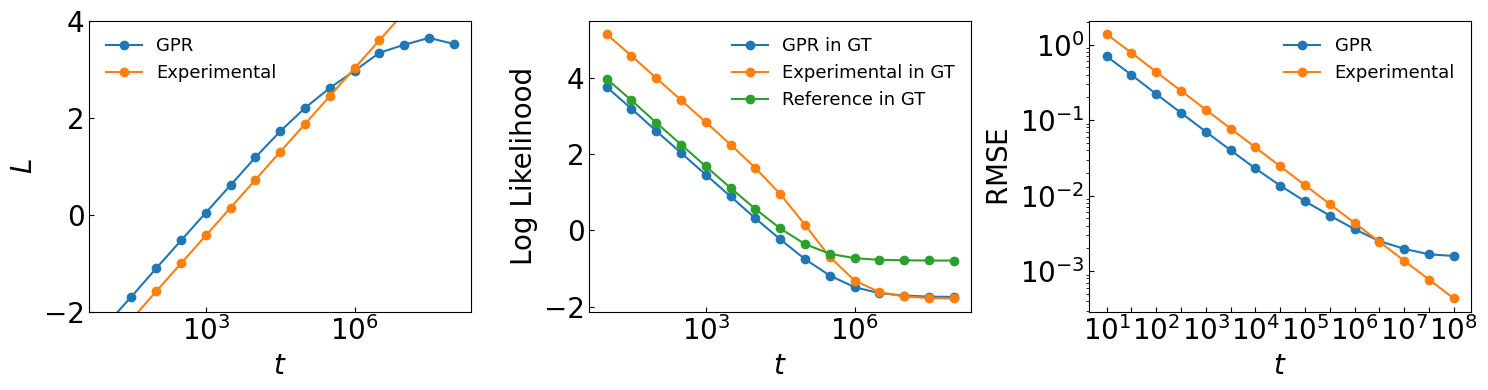

In [39]:
# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# Plot the log likelihood as a function of n_sample
axs[0].plot(n_sample_list, list_L_gpr, '-o', color='C0', label='GPR')
axs[0].plot(n_sample_list, list_L_exp, '-o', color='C1', label='Experimental')
axs[0].legend(frameon=False, fontsize=13)
axs[0].set_xticks(n_sample_list)
axs[0].set_xscale('log')
axs[0].set_ylim([-2, 4])
axs[0].tick_params(direction='in', labelsize=20)
axs[0].set_xlabel(r'$t$', fontsize=20)
axs[0].set_ylabel(r'$L$', fontsize=20)

# Plot the gain as a function of n_sample
axs[1].plot(n_sample_list, 1-list_G_acc_gpr, '-o', color='C0', label='GPR in GT')
axs[1].plot(n_sample_list, 1-list_G_acc_exp, '-o', color='C1', label='Experimental in GT')
axs[1].plot(n_sample_list, 1-list_G_m, '-o', color='C2', label='Reference in GT')
axs[1].legend(frameon=False, fontsize=13)
axs[1].set_xticks(n_sample_list)
axs[1].set_xscale('log')
axs[1].set_xscale('log')
# axs[1].set_ylim([-5, 2])
axs[1].tick_params(direction='in', labelsize=20)
axs[1].set_xlabel(r'$t$', fontsize=20)
axs[1].set_ylabel(r'Log Likelihood', fontsize=20)

# Plot the RMSE as a function of n_sample
axs[2].plot(n_sample_list, np.sqrt(list_mse_gpr), '-o', color='C0', label='GPR')
axs[2].plot(n_sample_list, np.sqrt(list_mse_exp), '-o', color='C1', label='Experimental')
axs[2].legend(frameon=False, fontsize=13)
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xticks(n_sample_list)
axs[2].tick_params(direction='in', labelsize=20)
axs[2].set_xlabel(r'$t$', fontsize=20)
axs[2].set_ylabel(r'$\mathrm{RMSE}$', fontsize=20)

plt.tight_layout()
plt.show()


Slope: -0.5035093458125831


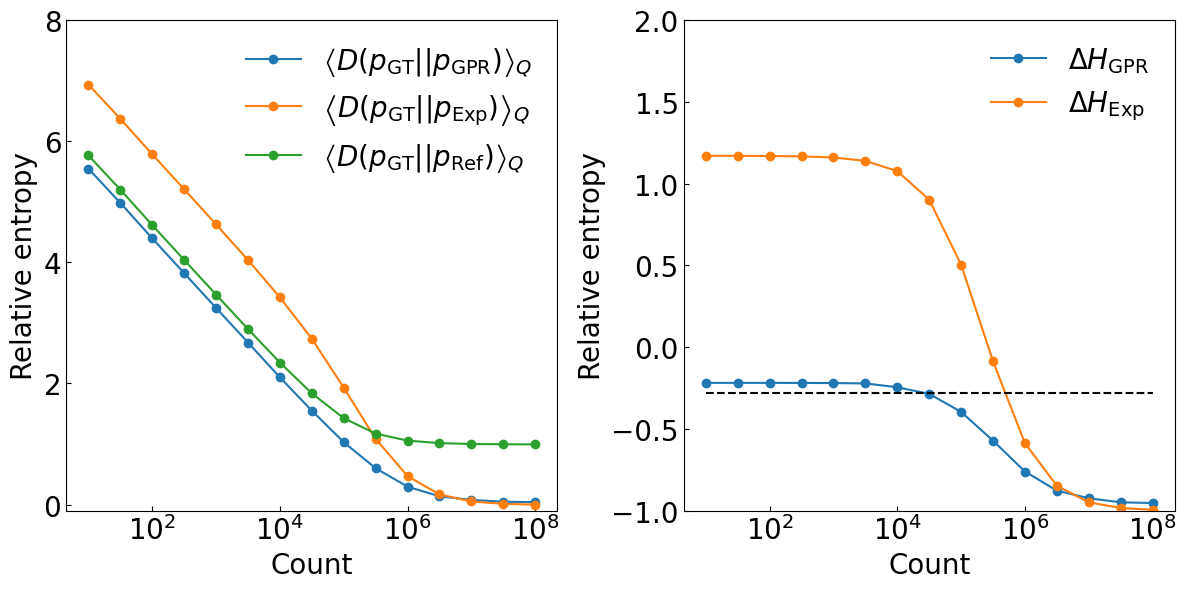

In [40]:
h_gt_gt = f_log_likelihood((y_gt), sigma_gt, (y_gt), sigma_gt, z_list=np.linspace(-4, 4, 49))/len(q)

# Filter the data for n_sample_list < 10000
mask = n_sample_list < 10000
x_fit = np.log(n_sample_list[mask])
y_fit = list_G_acc_exp[-1] - list_G_acc_exp[mask]

# Calculate the slope
slope, intercept = np.polyfit(x_fit, y_fit, 1)
print(f"Slope: {slope}")

# Create duplicates for quantities to be plotted to prevent overwrite
list_G_acc_gpr_dup = list_G_acc_gpr.copy()
list_G_acc_exp_dup = list_G_acc_exp.copy()
list_G_m_dup = list_G_m.copy()
# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the gain as a function of time
ax = axs[0]
ax.plot(n_sample_list, list_G_acc_exp[-1]-list_G_acc_gpr, '-o', color='C0', label=r'$\left\langle D(p_{\mathrm{GT}}||p_{\mathrm{GPR}})\right\rangle_{Q}$')
ax.plot(n_sample_list, list_G_acc_exp[-1]-list_G_acc_exp, '-o', color='C1', label=r'$\left\langle D(p_{\mathrm{GT}}||p_{\mathrm{Exp}})\right\rangle_{Q}$')
ax.plot(n_sample_list, list_G_acc_exp[-1]-list_G_m, '-o', color='C2', label=r'$\left\langle D(p_{\mathrm{GT}}||p_{\mathrm{Ref}})\right\rangle_{Q}$')
ax.legend(frameon=False, fontsize=20)
ax.set_xticks(n_sample_list)
ax.set_xscale('log')
ax.set_ylim([-0.1, 8])
ax.tick_params(direction='in', labelsize=20)
ax.set_xlabel(r'Count', fontsize=20)
ax.set_ylabel(r'Relative entropy', fontsize=20)

# Plot the gain as a function of time
ax = axs[1]
ax.plot(n_sample_list, list_G_m-list_G_acc_gpr, '-o', color='C0', label=r'$\Delta H_\mathrm{GPR}$')
ax.plot(n_sample_list, list_G_m-list_G_acc_exp, '-o', color='C1', label=r'$\Delta H_\mathrm{Exp}$')
ax.plot(n_sample_list, np.ones_like(n_sample_list)*-0.28, '--k')
ax.legend(frameon=False, fontsize=20)
ax.set_xticks(n_sample_list)
ax.set_xscale('log')
ax.set_ylim([-1, 2])
ax.tick_params(direction='in', labelsize=20)
ax.set_xlabel(r'Count', fontsize=20)
ax.set_ylabel(r'Relative entropy', fontsize=20)

plt.tight_layout()


/tmp/ipykernel_2781091/743787956.py:115: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "sr" (-> color='r'). The keyword argument will take precedence.
  ax.plot((list_G_acc_exp[-1]-list_G_acc_exp)[:-2], (n_sample_list/time_gpr)[:-2], 'sr', color='r', fillstyle='none', ms=12, markeredgewidth=2)
/tmp/ipykernel_2781091/743787956.py:116: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  ax.plot([-0.5,8], [1, 1], '--k', color='k')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Slope: -0.5035093458125831


/tmp/ipykernel_2781091/743787956.py:129: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim([0, 30])


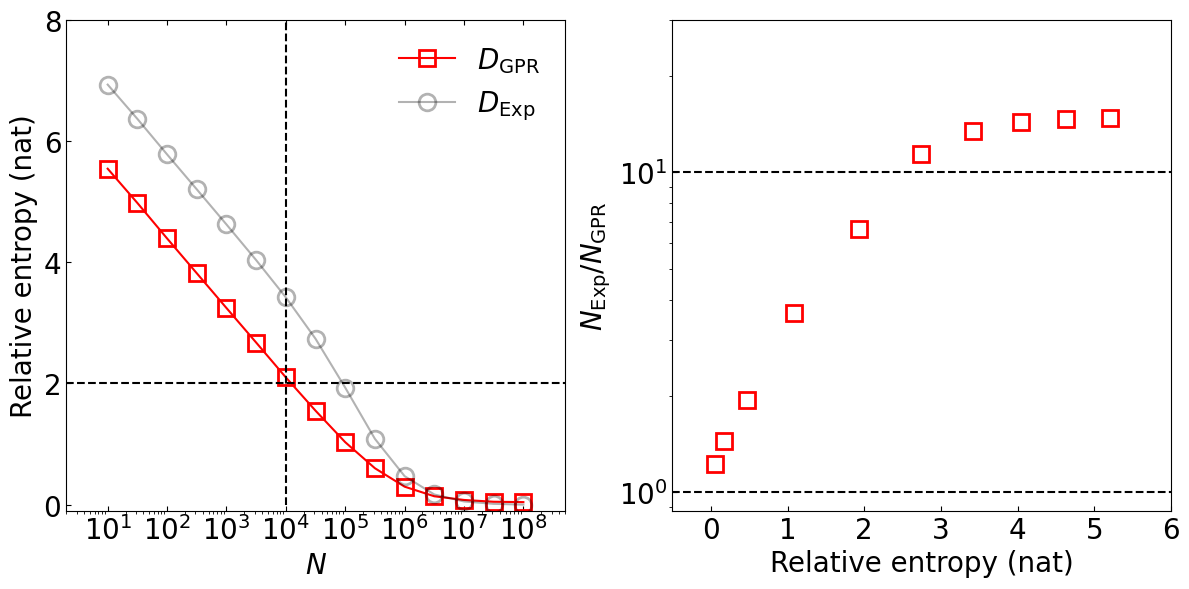

In [41]:
h_gt_gt = f_log_likelihood((y_gt), sigma_gt, (y_gt), sigma_gt, z_list=np.linspace(-4, 4, 49))/len(q)

# Filter the data for n_sample_list < 10000
mask = n_sample_list < 10000
x_fit = np.log(n_sample_list[mask])
y_fit = list_G_acc_exp[-1] - list_G_acc_exp[mask]

# Calculate the slope
slope, intercept = np.polyfit(x_fit, y_fit, 1)
print(f"Slope: {slope}")

# Create duplicates for quantities to be plotted to prevent overwrite
list_G_acc_gpr_dup = list_G_acc_gpr.copy()
list_G_acc_exp_dup = list_G_acc_exp.copy()
list_G_m_dup = list_G_m.copy()
# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the gain as a function of time
ax = axs[0]
# ax.plot(n_sample_list, list_G_acc_exp[-1]-list_G_acc_gpr, '-o', color='C0', label=r'$\left\langle D(p_{\mathrm{GT}}||p_{\mathrm{GPR}})\right\rangle_{Q}$')
# ax.plot(n_sample_list, list_G_acc_exp[-1]-list_G_acc_exp, '-o', color='C1', label=r'$\left\langle D(p_{\mathrm{GT}}||p_{\mathrm{Exp}})\right\rangle_{Q}$')
ax.plot(n_sample_list, list_G_acc_exp[-1]-list_G_acc_gpr, '-s', color='r', label=r'$D_{\mathrm{GPR}}$', fillstyle='none', ms=12, markeredgewidth=2)
ax.plot(n_sample_list, list_G_acc_exp[-1]-list_G_acc_exp, '-o', color='k', label=r'$D_{\mathrm{Exp}}$', alpha=0.3, fillstyle='none', ms=12, markeredgewidth=2)
# ax.plot(n_sample_list, list_G_acc_exp[-1]-list_G_m, '-o', color='C2', label=r'$\left\langle D(p_{\mathrm{GT}}||p_{\mathrm{Ref}})\right\rangle_{Q}$')
ax.plot([2e0, 5e8], [2,2], '--k')
ax.plot([1e4,1e4], [0,50], '--k')

ax.legend(frameon=False, fontsize=20)
ax.set_xticks(n_sample_list)
ax.set_xscale('log')
ax.set_xlim([2e0, 5e8])
ax.set_ylim([-0.1, 8])
ax.tick_params(direction='in', labelsize=20, top=True)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=9)
ax.xaxis.set_minor_locator(locmin)
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
ax.xaxis.set_major_locator(locmaj)

ax.set_xlabel(r'$N$', fontsize=20)
ax.set_ylabel(r'Relative entropy (nat)', fontsize=20)

# Plot time required for GPR to reach the same relative entropy as the experimental data
ax = axs[1]

# f_interp_exp = interp1d(list_G_acc_exp[-1]-list_G_acc_exp, n_sample_list, kind='linear', fill_value='extrapolate')

# time_exp = np.zeros_like(n_sample_list)
# for i in range(len(list_G_acc_gpr)):
#     H_gpr_gt_i = list_G_acc_exp[-1]-list_G_acc_gpr[i]
#     time_exp[i] = f_interp_exp(H_gpr_gt_i)

# ax.plot(n_sample_list, time_exp, 'or', color='C1')
# ax.plot([1e1/2, 1e8*2], [1e1/2, 1e8*2], '--k', color='C0')
# ax.legend(frameon=False, fontsize=20)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim([1e1/2, 1e8*2])
# ax.set_ylim([1e1/2, 1e8*2])
# ax.legend(frameon=False, fontsize=20)
# # ax.set_xticks(n_sample_list)
# ax.tick_params(direction='in', labelsize=20)
# # ax.tick_params(axis='x', direction='in', labelsize=18)
# ax.set_xlabel(r'$t_\mathrm{GPR} \ (\mathrm{s})$', fontsize=20)
# ax.set_ylabel(r'$t_\mathrm{Exp} \ (\mathrm{s})$', fontsize=20)

f_interp_gpr = interp1d(list_G_acc_gpr[-1]-list_G_acc_gpr, n_sample_list, kind='linear', fill_value='extrapolate')

time_gpr = np.zeros_like(n_sample_list)
for i in range(len(list_G_acc_exp)):
    H_exp_gt_i = list_G_acc_exp[-1]-list_G_acc_exp[i]
    time_gpr[i] = f_interp_gpr(H_exp_gt_i)

def f_not_used():
    '''
        fold unused code
    '''
    # ax.plot(n_sample_list, time_gpr, 'sr', color='r', fillstyle='none', ms=12, markeredgewidth=2, label = r'$N_\mathrm{GPR}$')  
    # ax.plot([1e1/2, 1e8*2], [1e1/2, 1e8*2], '--k', color='k', alpha=0.3, label = r'$N_\mathrm{Exp}$', fillstyle='none', ms=12, markeredgewidth=2)
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    # # ax.set_xticks(n_sample_list)
    # ax.tick_params(direction='in', labelsize=20)
    # locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=9)
    # ax.xaxis.set_minor_locator(locmin)
    # ax.yaxis.set_minor_locator(locmin)
    # locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
    # ax.xaxis.set_major_locator(locmaj)
    # ax.yaxis.set_major_locator(locmaj)
    # # ax.tick_params(axis='x', direction='in', labelsize=18)

    # ax.set_xlim([1e1/2, 1e7*2])
    # ax.set_ylim([1e1/2, 1e7*2])
    # ax.set_xlabel(r'$N_\mathrm{Exp}$', fontsize=20)
    # ax.set_ylabel(r'$N$', fontsize=20)
    # ax.legend(frameon=False, fontsize=20, loc='lower right')

    # ax.plot((list_G_acc_exp[-1]-list_G_acc_exp)[:-2], (time_gpr/n_sample_list)[:-2], 'sr', color='r', fillstyle='none', ms=12, markeredgewidth=2)  
    # ax.plot([-0.5,8], [1, 1], '--k', color='k', alpha=0.3)
    # ax.legend(frameon=False, fontsize=20)
    # # ax.set_xscale('log')
    # ax.set_yscale('log')
    # ax.legend(frameon=False, fontsize=20)
    # # ax.set_xticks(n_sample_list)
    # ax.tick_params(direction='in', labelsize=20)
    # ax.tick_params(axis='x', direction='in', labelsize=20)

    # # ax.set_xlim([1e2/2, 1e7*2])
    # ax.set_xticks(np.arange(0, 8, 1))
    # ax.set_xlim([-0.5, 6])
    # ax.set_ylim([1e-2, 2e0])
    # ax.set_xlabel(r'Relative entropy (nat)', fontsize=20)
    # ax.set_ylabel(r'$N_\mathrm{GPR}/N_\mathrm{Exp}$', fontsize=20)

ax.plot((list_G_acc_exp[-1]-list_G_acc_exp)[:-2], (n_sample_list/time_gpr)[:-2], 'sr', color='r', fillstyle='none', ms=12, markeredgewidth=2)  
ax.plot([-0.5,8], [1, 1], '--k', color='k')
ax.plot([-0.5,8], [10, 10], '--k')
ax.legend(frameon=False, fontsize=20)
# ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(frameon=False, fontsize=20)
# ax.set_xticks(n_sample_list)
ax.tick_params(direction='in', labelsize=20)
ax.tick_params(axis='x', direction='in', labelsize=20)

# ax.set_xlim([1e2/2, 1e7*2])
ax.set_xticks(np.arange(0, 8, 1))
ax.set_xlim([-0.5, 6])
ax.set_ylim([0, 30])
ax.set_xlabel(r'Relative entropy (nat)', fontsize=20)
ax.set_ylabel(r'$N_\mathrm{Exp}/N_\mathrm{GPR}$', fontsize=20)

plt.tight_layout()


/tmp/ipykernel_2781091/1985327936.py:69: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "sr" (-> color='r'). The keyword argument will take precedence.
  ax.plot(n_sample_list, time_gpr, 'sr', color='r', fillstyle='none', ms=12, markeredgewidth=2, label = r'$N_\mathrm{GPR}$')
/tmp/ipykernel_2781091/1985327936.py:70: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  ax.plot([1e1/2, 1e8*2], [1e1/2, 1e8*2], '--k', color='k', alpha=0.3, label = r'$N_\mathrm{Exp}$', fillstyle='none', ms=12, markeredgewidth=2)
/tmp/ipykernel_2781091/1985327936.py:91: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "sr" (-> color='r'). The keyword argument will take precedence.
  ax.plot(n_sample_list[:-2], (time_gpr/n_sample_list)[:-2], 'sr', color='r', fillstyle='none', ms=12, markeredgewidth=2)
/tmp/ipykernel

Slope: -0.5035093458125831


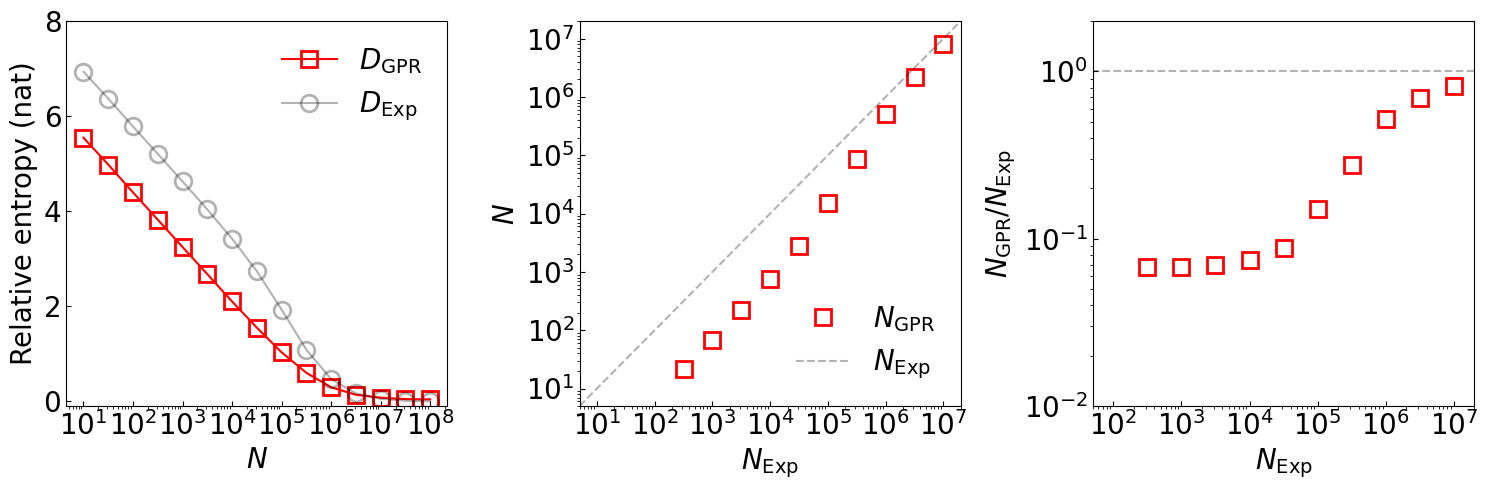

In [42]:
h_gt_gt = f_log_likelihood((y_gt), sigma_gt, (y_gt), sigma_gt, z_list=np.linspace(-4, 4, 49))/len(q)

# Filter the data for n_sample_list < 10000
mask = n_sample_list < 10000
x_fit = np.log(n_sample_list[mask])
y_fit = list_G_acc_exp[-1] - list_G_acc_exp[mask]

# Calculate the slope
slope, intercept = np.polyfit(x_fit, y_fit, 1)
print(f"Slope: {slope}")

# Create duplicates for quantities to be plotted to prevent overwrite
list_G_acc_gpr_dup = list_G_acc_gpr.copy()
list_G_acc_exp_dup = list_G_acc_exp.copy()
list_G_m_dup = list_G_m.copy()
# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the gain as a function of time
ax = axs[0]
# ax.plot(n_sample_list, list_G_acc_exp[-1]-list_G_acc_gpr, '-o', color='C0', label=r'$\left\langle D(p_{\mathrm{GT}}||p_{\mathrm{GPR}})\right\rangle_{Q}$')
# ax.plot(n_sample_list, list_G_acc_exp[-1]-list_G_acc_exp, '-o', color='C1', label=r'$\left\langle D(p_{\mathrm{GT}}||p_{\mathrm{Exp}})\right\rangle_{Q}$')
ax.plot(n_sample_list, list_G_acc_exp[-1]-list_G_acc_gpr, '-s', color='r', label=r'$D_{\mathrm{GPR}}$', fillstyle='none', ms=12, markeredgewidth=2)
ax.plot(n_sample_list, list_G_acc_exp[-1]-list_G_acc_exp, '-o', color='k', label=r'$D_{\mathrm{Exp}}$', alpha=0.3, fillstyle='none', ms=12, markeredgewidth=2)
# ax.plot(n_sample_list, list_G_acc_exp[-1]-list_G_m, '-o', color='C2', label=r'$\left\langle D(p_{\mathrm{GT}}||p_{\mathrm{Ref}})\right\rangle_{Q}$')
ax.legend(frameon=False, fontsize=20)
ax.set_xticks(n_sample_list)
ax.set_xscale('log')
ax.set_ylim([-0.1, 8])
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=9)
ax.xaxis.set_minor_locator(locmin)
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
ax.xaxis.set_major_locator(locmaj)
ax.tick_params(direction='in', labelsize=20)
ax.set_xlabel(r'$N$', fontsize=20)
ax.set_ylabel(r'Relative entropy (nat)', fontsize=20)

# Plot time required for GPR to reach the same relative entropy as the experimental data
ax = axs[1]

# f_interp_exp = interp1d(list_G_acc_exp[-1]-list_G_acc_exp, n_sample_list, kind='linear', fill_value='extrapolate')

# time_exp = np.zeros_like(n_sample_list)
# for i in range(len(list_G_acc_gpr)):
#     H_gpr_gt_i = list_G_acc_exp[-1]-list_G_acc_gpr[i]
#     time_exp[i] = f_interp_exp(H_gpr_gt_i)

# ax.plot(n_sample_list, time_exp, 'or', color='C1')
# ax.plot([1e1/2, 1e8*2], [1e1/2, 1e8*2], '--k', color='C0')
# ax.legend(frameon=False, fontsize=20)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim([1e1/2, 1e8*2])
# ax.set_ylim([1e1/2, 1e8*2])
# ax.legend(frameon=False, fontsize=20)
# # ax.set_xticks(n_sample_list)
# ax.tick_params(direction='in', labelsize=20)
# # ax.tick_params(axis='x', direction='in', labelsize=18)
# ax.set_xlabel(r'$t_\mathrm{GPR} \ (\mathrm{s})$', fontsize=20)
# ax.set_ylabel(r'$t_\mathrm{Exp} \ (\mathrm{s})$', fontsize=20)

f_interp_gpr = interp1d(list_G_acc_gpr[-1]-list_G_acc_gpr, n_sample_list, kind='linear', fill_value='extrapolate')

time_gpr = np.zeros_like(n_sample_list)
for i in range(len(list_G_acc_exp)):
    H_exp_gt_i = list_G_acc_exp[-1]-list_G_acc_exp[i]
    time_gpr[i] = f_interp_gpr(H_exp_gt_i)

ax.plot(n_sample_list, time_gpr, 'sr', color='r', fillstyle='none', ms=12, markeredgewidth=2, label = r'$N_\mathrm{GPR}$')  
ax.plot([1e1/2, 1e8*2], [1e1/2, 1e8*2], '--k', color='k', alpha=0.3, label = r'$N_\mathrm{Exp}$', fillstyle='none', ms=12, markeredgewidth=2)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xticks(n_sample_list)
ax.tick_params(direction='in', labelsize=20)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=9)
ax.xaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_locator(locmin)
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
ax.xaxis.set_major_locator(locmaj)
ax.yaxis.set_major_locator(locmaj)
# ax.tick_params(axis='x', direction='in', labelsize=18)

ax.set_xlim([1e1/2, 1e7*2])
ax.set_ylim([1e1/2, 1e7*2])
ax.set_xlabel(r'$N_\mathrm{Exp}$', fontsize=20)
ax.set_ylabel(r'$N$', fontsize=20)
ax.legend(frameon=False, fontsize=20, loc='lower right')

ax = axs[2]

ax.plot(n_sample_list[:-2], (time_gpr/n_sample_list)[:-2], 'sr', color='r', fillstyle='none', ms=12, markeredgewidth=2)  
ax.plot([1e1/2, 1e7*2], [1, 1], '--k', color='k', alpha=0.3)
ax.legend(frameon=False, fontsize=20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(frameon=False, fontsize=20)
# ax.set_xticks(n_sample_list)
ax.tick_params(direction='in', labelsize=20)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=9)
ax.xaxis.set_minor_locator(locmin)
# ax.yaxis.set_minor_locator(locmin)
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
ax.xaxis.set_major_locator(locmaj)
# ax.yaxis.set_major_locator(locmaj)
ax.tick_params(axis='x', direction='in', labelsize=20)

ax.set_xlim([1e2/2, 1e7*2])
ax.set_ylim([1e-2, 2e0])
ax.set_xlabel(r'$N_\mathrm{Exp}$', fontsize=20)
ax.set_ylabel(r'$N_\mathrm{GPR}/N_\mathrm{Exp}$', fontsize=20)

# ax.plot((list_G_acc_exp[-1]-list_G_acc_exp)[:-2], (time_gpr/n_sample_list)[:-2], 'sr', color='r', fillstyle='none', ms=12, markeredgewidth=2)  
# ax.plot([-0.5,8], [1, 1], '--k', color='k', alpha=0.3)
# ax.legend(frameon=False, fontsize=20)
# # ax.set_xscale('log')
# ax.set_yscale('log')
# ax.legend(frameon=False, fontsize=20)
# # ax.set_xticks(n_sample_list)
# ax.tick_params(direction='in', labelsize=20)
# ax.tick_params(axis='x', direction='in', labelsize=20)

# # ax.set_xlim([1e2/2, 1e7*2])
# ax.set_xticks(np.arange(0, 8, 1))
# ax.set_xlim([-0.5, 6])
# ax.set_ylim([1e-2, 2e0])
# ax.set_xlabel(r'Relative entropy (nat)', fontsize=20)
# ax.set_ylabel(r'$N_\mathrm{GPR}/N_\mathrm{Exp}$', fontsize=20)

plt.tight_layout()


/tmp/ipykernel_2781091/2491548081.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "sr" (-> color='r'). The keyword argument will take precedence.
  ax.plot(n_sample_list[:-2], (time_gpr/n_sample_list)[:-2], 'sr', color='r', fillstyle='none', ms=12, markeredgewidth=2)
/tmp/ipykernel_2781091/2491548081.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  ax.plot([1e1/2, 1e7*2], [1, 1], '--k', color='k', alpha=0.3)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, '$N_\\mathrm{GPR}/N_\\mathrm{Exp}$')

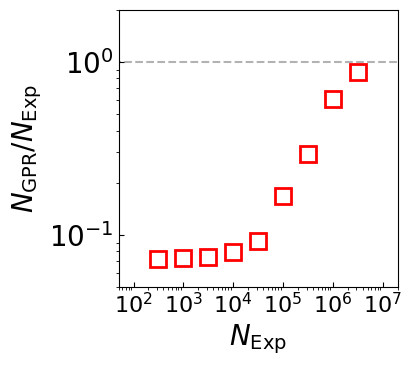

In [43]:
fig, axs = plt.subplots(1, 1, figsize=(3.6, 3.6))
ax = axs
f_interp_gpr = interp1d(list_G_acc_exp[-1]-list_G_acc_gpr, n_sample_list, kind='linear', fill_value='extrapolate')

time_gpr = np.zeros_like(n_sample_list)
for i in range(len(list_G_acc_exp)):
    H_exp_gt_i = list_G_acc_exp[-1]-list_G_acc_exp[i]
    time_gpr[i] = f_interp_gpr(H_exp_gt_i)

ax.plot(n_sample_list[:-2], (time_gpr/n_sample_list)[:-2], 'sr', color='r', fillstyle='none', ms=12, markeredgewidth=2)  
ax.plot([1e1/2, 1e7*2], [1, 1], '--k', color='k', alpha=0.3)
ax.legend(frameon=False, fontsize=20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(frameon=False, fontsize=20)
# ax.set_xticks(n_sample_list)
ax.tick_params(direction='in', labelsize=20)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=9)
ax.xaxis.set_minor_locator(locmin)
# ax.yaxis.set_minor_locator(locmin)
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
ax.xaxis.set_major_locator(locmaj)
# ax.yaxis.set_major_locator(locmaj)
ax.tick_params(axis='x', direction='in', labelsize=16)

ax.set_xlim([1e2/2, 1e7*2])
ax.set_ylim([5e-2, 2e0])
ax.set_xlabel(r'$N_\mathrm{Exp}$', fontsize=20)
ax.set_ylabel(r'$N_\mathrm{GPR}/N_\mathrm{Exp}$', fontsize=20)

/tmp/ipykernel_2781091/4276682894.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "sr" (-> color='r'). The keyword argument will take precedence.
  ax.plot(n_sample_list[:-2], (n_sample_list/time_gpr)[:-2], 'sr', color='r', fillstyle='none', ms=12, markeredgewidth=2)
/tmp/ipykernel_2781091/4276682894.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  ax.plot([1e1/2, 1e7*2], [1, 1], '--k', color='k', alpha=0.3)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, '$N_\\mathrm{Exp}/N_\\mathrm{GPR}$')

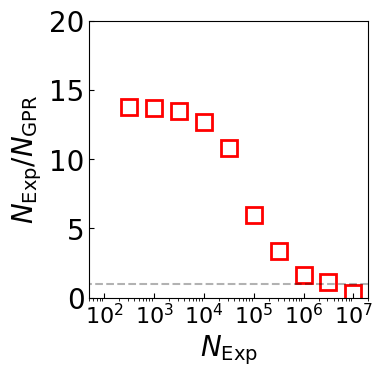

In [44]:
fig, axs = plt.subplots(1, 1, figsize=(3.6, 3.6))
ax = axs
f_interp_gpr = interp1d(list_G_acc_exp[-1]-list_G_acc_gpr, n_sample_list, kind='linear', fill_value='extrapolate')

time_gpr = np.zeros_like(n_sample_list)
for i in range(len(list_G_acc_exp)):
    H_exp_gt_i = list_G_acc_exp[-1]-list_G_acc_exp[i]
    time_gpr[i] = f_interp_gpr(H_exp_gt_i)

ax.plot(n_sample_list[:-2], (n_sample_list/time_gpr)[:-2], 'sr', color='r', fillstyle='none', ms=12, markeredgewidth=2)  
ax.plot([1e1/2, 1e7*2], [1, 1], '--k', color='k', alpha=0.3)
ax.legend(frameon=False, fontsize=20)
ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend(frameon=False, fontsize=20)
# ax.set_xticks(n_sample_list)
ax.tick_params(direction='in', labelsize=20)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=9)
ax.xaxis.set_minor_locator(locmin)
# ax.yaxis.set_minor_locator(locmin)
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
ax.xaxis.set_major_locator(locmaj)
# ax.yaxis.set_major_locator(locmaj)
ax.tick_params(axis='x', direction='in', labelsize=16)

ax.set_xlim([1e2/2, 1e7*2])
ax.set_ylim([0, 20])
ax.set_xlabel(r'$N_\mathrm{Exp}$', fontsize=20)
ax.set_ylabel(r'$N_\mathrm{Exp}/N_\mathrm{GPR}$', fontsize=20)

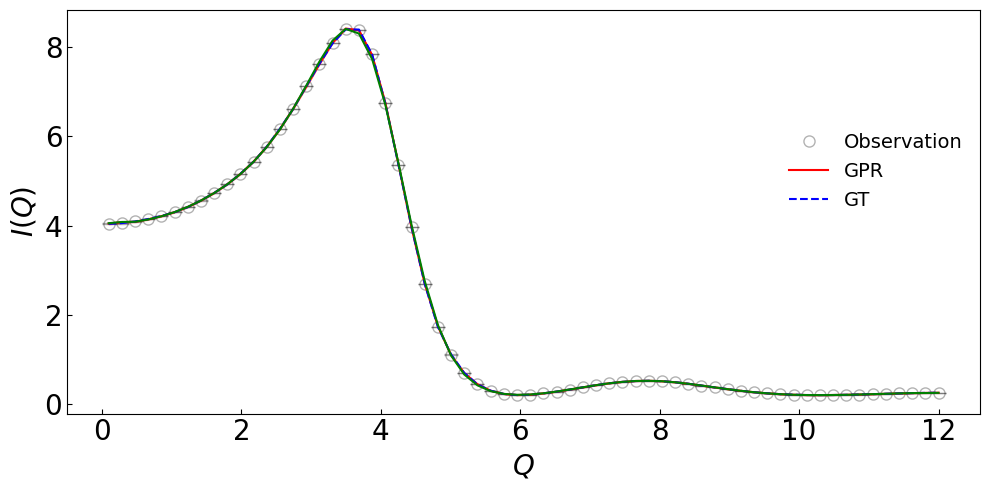

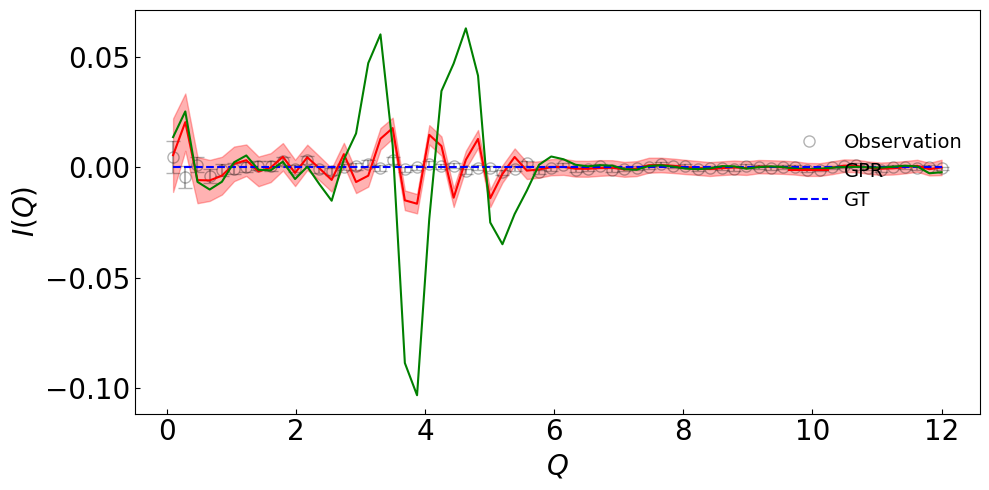

In [45]:
y_ref = y_gt

# plot the GPR result
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 1, 1)

ax.plot(q_x, y + y_bg, 'ok', markersize=8, fillstyle='none', label='Observation', alpha=0.3) 
ax.errorbar(q_x, y + y_bg, yerr=y_err_pixel, fmt='none', ecolor='k', capsize=5, alpha=0.3)
ax.plot(q_s, mu_s + y_bg, '-r', label='GPR')
ax.fill_between(q_s, mu_s - std_s + y_bg, mu_s + std_s + y_bg, color='r', alpha=0.3)

ax.plot(q, y_gt , '--b', label='GT')

ax.plot(q_x, y_bg, '-g')

ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)$', fontsize=20)

ax.tick_params(direction='in', labelsize=20)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylim([5e-2, 2e1])
# ax.set_ylim([0, 5])

ax.legend(frameon=False, fontsize=14, loc='right', bbox_to_anchor=(1, 0.6))
plt.tight_layout()

# plot the GPR result
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 1, 1)

ax.plot(q_x, y + y_bg-y_ref, 'ok', markersize=8, fillstyle='none', label='Observation', alpha=0.3) 
ax.errorbar(q_x, y + y_bg-y_ref, yerr=y_err_pixel, fmt='none', ecolor='k', capsize=5, alpha=0.3)
ax.plot(q_s, mu_s + y_bg-y_ref, '-r', label='GPR')
ax.fill_between(q_s, mu_s - std_s + y_bg-y_ref, mu_s + std_s + y_bg-y_ref, color='r', alpha=0.3)

ax.plot(q, y_gt-y_ref , '--b', label='GT')

ax.plot(q_x, y_bg-y_ref, '-g')

ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)$', fontsize=20)

ax.tick_params(direction='in', labelsize=20)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylim([5e-2, 2e1])
# ax.set_ylim([0, 5])

ax.legend(frameon=False, fontsize=14, loc='right', bbox_to_anchor=(1, 0.6))
plt.tight_layout()

## GP of GP

In [14]:
def f_not_used():
    '''
        fold unused code
    '''
    # n_trial = 1
    # filter_size = 0.4
    # I_bg = I_inc
    # use_log_I = False
    # use_log_Q = False

    # # Transformations on Q and I(Q)
    # f_Q = lambda q: q
    # f_inv_Q = lambda fq: fq
    # if use_log_Q:
    #     f_Q = lambda q: np.log(q)
    #     f_inv_Q = lambda fq: np.exp(fq)


    # f_I = lambda I: I
    # f_inv_I = lambda fI: fI
    # # if use_log_I:
    # #     f_I = lambda I: np.log(I+I_bg)
    # #     f_inv_I = lambda fI: np.exp(fI)-I_bg
    # if use_log_I:
    #     f_I = lambda I: f_loglin(I, x_c=I_bg*2)
    #     f_inv_I = lambda fI: f_loglin_inv(fI, y_c=np.log(I_bg*2))

    # def get_viridis_color(value):
    #     cmap = plt.get_cmap('viridis')
    #     return cmap(value)

    # fig = plt.figure(figsize=(5, 5))

    # # n_sample_list = np.array([1000, 2000, 5000, 10000, 20000, 50000, 100000])
    # # n_sample_list = np.linspace(1000, 20000, 10)
    # n_sample_list = np.logspace(1, 8, 15)

    # list_L_gpr = []
    # list_L_exp = []
    # list_mse_gpr = []
    # list_mse_exp = []
    # list_G_acc_gpr = []
    # list_G_acc_exp = []
    # list_G_m = []
    # for i_n, n_sample in enumerate(n_sample_list):
        
    #     ax = plt.subplot(1, 1, 1)

    #     n_sample = int(n_sample)
    #     color = get_viridis_color(i_n/(len(n_sample_list)-1))
        
    #     dq = q_grid[1] - q_grid[0]

    #     log_likelihood_gt_exp = 0
    #     log_likelihood_gt_gpr = 0
    #     mse_exp = 0
    #     mse_gpr = 0
    #     G_acc_gpr = 0
    #     G_acc_exp = 0
    #     G_m = 0
        
    #     for i_trial in range(n_trial):
    #         seed_trial = np.random.randint(1e6)
    #         I_q_grid = f_I_q(n_sample, p_qxy, seed=None) ## count per pixel
    #         I_q, sum_q, n_pixels_q, I_pixels_q = f_I_q_rad(I_q_grid, q)
    #         I_q_th, _, _, _ = f_I_q_rad(p_qxy, q)
    #         I_q_th = I_q_th*n_sample
            
    #         #override I_q by given y_err
    #         y_err_pixel = np.sqrt(n_sample/np.sum(n_pixels_q)*(1/np.maximum(n_pixels_q,np.ones_like(q))))
    #         np.random.seed(seed_trial)
    #         I_q = (I_q_th + np.random.normal(size = I_q.shape)*y_err_pixel)
    #         np.random.seed(None)
            
    #         I_q_gf = np.zeros_like(q)
    #         for i_iterate in range(1):
    #             I_q_gf_i = np.zeros_like(q)
    #             I_iterate = I_q - I_q_gf
    #             for i in range(len(q)):
    #                 weight_list = np.exp(-((f_Q(q[i])-f_Q(q))/filter_size)**2/2)
    #                 weight_list = weight_list/np.sum(weight_list)
    #                 I_q_gf_i[i] = np.sum(I_iterate*weight_list)
    #             n_sm = 2
    #             I_q_gf_i[n_sm:-n_sm] = desmear(f_Q(q), I_q_gf_i, I_q_gf_i*0+1, np.ones_like(I_q_gf)*filter_size, n=n_sm, sigmascale=1)
    #             I_q_gf = I_q_gf + I_q_gf_i
            
    #         I_err_q = np.sqrt(1/n_pixels_q*[np.sum(I) for I in I_pixels_q]) # var: 1/n_pixels*sum(I)

    #         ## GPR
    #         sigma_list = np.logspace(-1, 3, 25)
    #         log_likelihood_list = []
    #         for sigma in sigma_list:
    #             lmbda = 0.36
    #             # sigma = 10

    #             ## define kernel function
    #             y_data = f_I(I_q/n_sample*n_grid)
    #             y_gt = f_I(I_q_th/n_sample*n_grid)
    #             y_bg = f_I(I_q_gf/n_sample*n_grid)
    #             # y_bg = y_gt
    #             y = y_data-y_bg

    #             # y_err = np.sqrt(n_sample/np.sum(n_pixels_q)*1/np.maximum(sum_q,np.ones_like(q)))
    #             y_err_pixel = np.sqrt(n_sample/np.sum(n_pixels_q)*(1/np.maximum(n_pixels_q,np.ones_like(q))))/n_sample*n_grid
    #             y_err = y_err_pixel
    #             if use_log_I:
    #                 y_err = y_err_pixel*f_loglin_deriv(I_q/n_sample*n_grid, x_c=I_bg)

    #             # scale by a factor to check whether error estimation is correct
    #             m_factor = 1
    #             y_bg = y_bg*m_factor
    #             y_gt = y_gt*m_factor
    #             y = y*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))*np.random.normal(size = y.shape)
    #             y_err = y_err*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))
    #             y_data = y_data*m_factor
    #             sig_var = np.mean(y**2)
                
    #             # fluctuations of the prior distribution
    #             prior_sigma = np.sqrt(sig_var)
    #             # prior_sigma = np.sqrt(np.mean(y_err**2))
    #             # prior_sigma = np.sqrt(y_err**2+sig_var) 

    #             q_x = q
    #             q_s = q

    #             def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
    #                 if std_1 is None:
    #                     std_1 = np.ones_like(q1)
    #                 if std_2 is None:
    #                     std_2 = np.ones_like(q2)
    #                 K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
    #                 return K
                
    #             f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
    #             K_sigma = np.diag(f_y_err(y_err))
    #             # K_sigma = sigma**2*np.eye(len(q_x))
    #             K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma #+ 0*np.eye(len(q_x))
    #             K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
    #             k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

    #             L = np.linalg.cholesky(K_xx)
    #             alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
    #             v = np.linalg.solve(L, K_xs)
    #             mu_s = K_xs.T @ alpha
    #             cov_s = k_ss - v.T @ v
    #             var_s = np.diag(cov_s)*prior_sigma**2
    #             std_s = np.sqrt(var_s)

    #             # evaluate the log likelihood
    #             log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
    #             log_likelihood_list.append(log_likelihood)
                
    #         log_likelihood_list = np.array(log_likelihood_list)
    #         log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q_s)

    #         if n_sample == 10000:
    #             color = 'r'
    #         ax.plot(sigma_list, log_likelihood_list, '-', color=color, label=f'${n_sample:.0e}$'.replace('e+0', r'\times 10^'))
    #         ax.set_xscale('log')
    #         ax.set_ylim([-5, 5])
    #         ax.tick_params(direction='in', labelsize=20)
    #         ax.set_xlabel(r'$m_\sigma$', fontsize=20)
    #         ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

    #         sigma_best = sigma_list[np.argmax(log_likelihood_list)]
            
    #         # ax.legend(frameon=False, fontsize=13, ncol=2)
    #         plt.tight_layout()

    #         # GPR with best sigma
    #         f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
    #         K_sigma = np.diag(f_y_err(y_err))
    #         # K_sigma = sigma**2*np.eye(len(q_x))
    #         K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma
    #         K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
    #         k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

    #         L = np.linalg.cholesky(K_xx)
    #         alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
    #         v = np.linalg.solve(L, K_xs)
    #         mu_s = K_xs.T @ alpha
    #         cov_s = k_ss - v.T @ v
    #         var_s = np.diag(cov_s)*prior_sigma**2
    #         std_s = np.sqrt(var_s)

    #         n_repeat = 2
    #         for i in range(n_repeat):
    #             ## repeat the GPR with the GPR as smoothed background ----------------------------------------------------------------------------       
    #             y_data = f_I(I_q/n_sample*n_grid)
    #             y_bg = mu_s + y_bg
    #             y = y_data-y_bg

    #             # GPR with best sigma
    #             f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
    #             K_sigma = np.diag(f_y_err(y_err))
    #             # K_sigma = sigma**2*np.eye(len(q_x))
    #             K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma
    #             K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
    #             k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

    #             L = np.linalg.cholesky(K_xx)
    #             alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
    #             v = np.linalg.solve(L, K_xs)
    #             mu_s = K_xs.T @ alpha
    #             cov_s = k_ss - v.T @ v
    #             var_s = np.diag(cov_s)*prior_sigma**2
    #             std_s = np.sqrt(var_s)   
    #             ## repeat the GPR with the GPR as smoothed background ----------------------------------------------------------------------------        
            
    #         I_mean_GP = f_inv_I(mu_s + y_bg)
    #         I_std_GP = std_s
    #         if use_log_I:
    #             I_std_GP = std_s/f_loglin_deriv(I_q/n_sample*n_grid, x_c=I_bg)
                
    #         delta_gp_bg = np.sqrt((f_inv_I(y_gt)-f_inv_I(y_bg))**2)
    #         # sigma_gt = np.ones_like(y_gt)*(np.max(y_gt)-np.min(y_gt))*1e-3
    #         sigma_gt = prior_sigma
            
    #         # Calculate the in terms of cross entropy      
    #         # h_gt_m = -f_log_likelihood((y_gt), sigma_gt, (y_bg), prior_sigma, z_list=np.linspace(-4, 4, 49))/len(q)#, z_list=np.linspace(-4, 4, 49))/len(q)#
    #         # h_gt_gpr = -f_log_likelihood((y_gt), sigma_gt, (mu_s + y_bg), std_s, z_list=np.linspace(-4, 4, 49))/len(q)#, z_list=np.linspace(-4, 4, 49))/len(q)#
    #         # h_gt_exp = -f_log_likelihood((y_gt), sigma_gt, (y_data), y_err, z_list=np.linspace(-4, 4, 49))/len(q)#, z_list=np.linspace(-4, 4, 49))/len(q)#
            
    #         h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-4, 4, 49))/len(q)
    #         h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-4, 4, 49))/len(q)
    #         h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-4, 4, 49))/len(q)
            
    #         G_acc_gpr += h_gpr_gt#-h_m_gt
    #         G_acc_exp += h_exp_gt#-h_m_gt
    #         G_m += h_m_gt
            
    #         # likelihood of gt within the experimental prediction
    #         # log_likelihood_gt_exp += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), f_inv_I(y_data), y_err_pixel)#, z_list=np.linspace(-4, 4, 49))
    #         log_likelihood_gt_exp += f_log_likelihood((y_gt), sigma_gt, y_data, y_err_pixel)/len(q)#, z_list=np.linspace(-4, 4, 49))
            
    #         # likelihood of gt within the GPR prediction
    #         # log_likelihood_gt_gpr += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), I_mean_GP, I_std_GP)#, z_list=np.linspace(-4, 4, 49))
    #         log_likelihood_gt_gpr += f_log_likelihood((y_gt), sigma_gt, mu_s + y_bg, std_s)/len(q)#, z_list=np.linspace(-4, 4, 49))
            
    #         # mean squared error of gt and experimental prediction
    #         # mse_exp += f_mse(y + y_bg, y_gt)
    #         mse_exp += f_mse(f_inv_I(y_data),f_inv_I(y_gt))
            
    #         # mean squared error of gt and GPR prediction
    #         # mse_gpr += f_mse(mu_s + y_bg, y_gt)
    #         mse_gpr += f_mse(I_mean_GP, f_inv_I(y_gt))
            
    #     list_L_exp.append(log_likelihood_gt_exp/n_trial)
    #     list_L_gpr.append(log_likelihood_gt_gpr/n_trial)
    #     list_mse_exp.append(mse_exp/n_trial)
    #     list_mse_gpr.append(mse_gpr/n_trial)
    #     list_G_acc_gpr.append(G_acc_gpr/n_trial)
    #     list_G_acc_exp.append(G_acc_exp/n_trial)
    #     list_G_m.append(G_m/n_trial)

    # # convert the lists to numpy arrays
    # list_L_exp = np.array(list_L_exp)
    # list_L_gpr = np.array(list_L_gpr)
    # list_mse_exp = np.array(list_mse_exp)
    # list_mse_gpr = np.array(list_mse_gpr)
    # list_G_acc_gpr = np.array(list_G_acc_gpr)
    # list_G_acc_exp = np.array(list_G_acc_exp)
    # list_G_m = np.array(list_G_m)

In [15]:
# h_gt_gt = f_log_likelihood((y_gt), sigma_gt, (y_gt), sigma_gt, z_list=np.linspace(-4, 4, 49))/len(q)

# # Filter the data for n_sample_list < 10000
# mask = n_sample_list < 10000
# x_fit = np.log(n_sample_list[mask])
# y_fit = list_G_acc_exp[-1] - list_G_acc_exp[mask]

# # Calculate the slope
# slope, intercept = np.polyfit(x_fit, y_fit, 1)
# print(f"Slope: {slope}")

# # Create duplicates for quantities to be plotted to prevent overwrite
# list_G_acc_gpr_dup = list_G_acc_gpr.copy()
# list_G_acc_exp_dup = list_G_acc_exp.copy()
# list_G_m_dup = list_G_m.copy()
# # Create a figure with 3 subplots
# fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# # Plot the gain as a function of time
# ax = axs[0]
# ax.plot(n_sample_list, list_G_acc_exp[-1]-list_G_acc_gpr, '-o', color='C0', label=r'$\left\langle D(p_{\mathrm{GT}}||p_{\mathrm{GPR}})\right\rangle_{Q}$')
# ax.plot(n_sample_list, list_G_acc_exp[-1]-list_G_acc_exp, '-o', color='C1', label=r'$\left\langle D(p_{\mathrm{GT}}||p_{\mathrm{Exp}})\right\rangle_{Q}$')
# ax.plot(n_sample_list, list_G_acc_exp[-1]-list_G_m, '-o', color='C2', label=r'$\left\langle D(p_{\mathrm{GT}}||p_{\mathrm{Ref}})\right\rangle_{Q}$')
# ax.legend(frameon=False, fontsize=20)
# ax.set_xticks(n_sample_list)
# ax.set_xscale('log')
# ax.set_ylim([-0.1, 8])
# ax.tick_params(direction='in', labelsize=20)
# ax.set_xlabel(r'Count', fontsize=20)
# ax.set_ylabel(r'Relative entropy', fontsize=20)

# # Plot the gain as a function of time
# ax = axs[1]
# ax.plot(n_sample_list, list_G_m-list_G_acc_gpr, '-o', color='C0', label=r'$\Delta H_\mathrm{GPR}$')
# ax.plot(n_sample_list, list_G_m-list_G_acc_exp, '-o', color='C1', label=r'$\Delta H_\mathrm{Exp}$')
# ax.plot(n_sample_list, np.ones_like(n_sample_list)*-0.28, '--k')
# ax.legend(frameon=False, fontsize=20)
# ax.set_xticks(n_sample_list)
# ax.set_xscale('log')
# ax.set_ylim([-1, 2])
# ax.tick_params(direction='in', labelsize=20)
# ax.set_xlabel(r'Count', fontsize=20)
# ax.set_ylabel(r'Relative entropy', fontsize=20)

# plt.tight_layout()


In [16]:
# h_gt_gt = f_log_likelihood((y_gt), sigma_gt, (y_gt), sigma_gt, z_list=np.linspace(-4, 4, 49))/len(q)

# # Filter the data for n_sample_list < 10000
# mask = n_sample_list < 10000
# x_fit = np.log(n_sample_list[mask])
# y_fit = list_G_acc_exp[-1] - list_G_acc_exp[mask]

# # Calculate the slope
# slope, intercept = np.polyfit(x_fit, y_fit, 1)
# print(f"Slope: {slope}")

# # Create duplicates for quantities to be plotted to prevent overwrite
# list_G_acc_gpr_dup = list_G_acc_gpr.copy()
# list_G_acc_exp_dup = list_G_acc_exp.copy()
# list_G_m_dup = list_G_m.copy()
# # Create a figure with 3 subplots
# fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# # Plot the gain as a function of time
# ax = axs[0]
# ax.plot(n_sample_list, list_G_acc_exp[-1]-list_G_acc_gpr, '-o', color='C0', label=r'$\left\langle D(p_{\mathrm{GT}}||p_{\mathrm{GPR}})\right\rangle_{Q}$')
# ax.plot(n_sample_list, list_G_acc_exp[-1]-list_G_acc_exp, '-o', color='C1', label=r'$\left\langle D(p_{\mathrm{GT}}||p_{\mathrm{Exp}})\right\rangle_{Q}$')
# ax.plot(n_sample_list, list_G_acc_exp[-1]-list_G_m, '-o', color='C2', label=r'$\left\langle D(p_{\mathrm{GT}}||p_{\mathrm{Ref}})\right\rangle_{Q}$')
# ax.legend(frameon=False, fontsize=20)
# ax.set_xticks(n_sample_list)
# ax.set_xscale('log')
# ax.set_ylim([-0.1, 8])
# ax.tick_params(direction='in', labelsize=20)
# ax.set_xlabel(r'Count', fontsize=20)
# ax.set_ylabel(r'Relative entropy', fontsize=20)

# # Plot the gain as a function of time
# ax = axs[1]

# f_interp_exp = interp1d(list_G_acc_exp[-1]-list_G_acc_exp, n_sample_list, kind='linear', fill_value='extrapolate')

# time_exp = np.zeros_like(n_sample_list)
# for i in range(len(list_G_acc_gpr)):
#     H_gpr_gt_i = list_G_acc_exp[-1]-list_G_acc_gpr[i]
#     time_exp[i] = f_interp_exp(H_gpr_gt_i)

# ax.plot(n_sample_list, time_exp, 'or')
# ax.plot([1, 1000], [1, 1000], '--k')
# ax.legend(frameon=False, fontsize=20)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim([1, 1000])
# ax.set_ylim([1, 1000])
# ax.legend(frameon=False, fontsize=20)
# ax.set_xticks(n_sample_list)
# ax.set_xscale('log')
# ax.set_ylim([-1, 2])
# ax.tick_params(direction='in', labelsize=20)
# ax.set_xlabel(r'Count', fontsize=20)
# ax.set_ylabel(r'Relative entropy', fontsize=20)

# plt.tight_layout()


In [17]:
# y_ref = y_gt

# # plot the GPR result
# fig = plt.figure(figsize=(10, 5))
# ax = plt.subplot(1, 1, 1)

# ax.plot(q_x, y + y_bg, 'ok', markersize=8, fillstyle='none', label='Observation', alpha=0.3) 
# ax.errorbar(q_x, y + y_bg, yerr=y_err_pixel, fmt='none', ecolor='k', capsize=5, alpha=0.3)
# ax.plot(q_s, mu_s + y_bg, '-r', label='GPR')
# ax.fill_between(q_s, mu_s - std_s + y_bg, mu_s + std_s + y_bg, color='r', alpha=0.3)

# ax.plot(q, y_gt , '--b', label='GT')

# ax.plot(q_x, y_bg, '-g')

# ax.set_xlabel(r'$Q$', fontsize=20)
# ax.set_ylabel(r'$I(Q)$', fontsize=20)

# ax.tick_params(direction='in', labelsize=20)
# # ax.set_xscale('log')
# # ax.set_yscale('log')
# # ax.set_ylim([5e-2, 2e1])
# # ax.set_ylim([0, 5])

# ax.legend(frameon=False, fontsize=14, loc='right', bbox_to_anchor=(1, 0.6))
# plt.tight_layout()

# # plot the GPR result
# fig = plt.figure(figsize=(10, 5))
# ax = plt.subplot(1, 1, 1)

# ax.plot(q_x, y + y_bg-y_ref, 'ok', markersize=8, fillstyle='none', label='Observation', alpha=0.3) 
# ax.errorbar(q_x, y + y_bg-y_ref, yerr=y_err_pixel, fmt='none', ecolor='k', capsize=5, alpha=0.3)
# ax.plot(q_s, mu_s + y_bg-y_ref, '-r', label='GPR')
# ax.fill_between(q_s, mu_s - std_s + y_bg-y_ref, mu_s + std_s + y_bg-y_ref, color='r', alpha=0.3)

# ax.plot(q, y_gt-y_ref , '--b', label='GT')

# ax.plot(q_x, y_bg-y_ref, '-g')

# ax.set_xlabel(r'$Q$', fontsize=20)
# ax.set_ylabel(r'$I(Q)$', fontsize=20)

# ax.tick_params(direction='in', labelsize=20)
# # ax.set_xscale('log')
# # ax.set_yscale('log')
# # ax.set_ylim([5e-2, 2e1])
# # ax.set_ylim([0, 5])

# ax.legend(frameon=False, fontsize=14, loc='right', bbox_to_anchor=(1, 0.6))
# plt.tight_layout()